In [1]:
from dotenv import load_dotenv

load_dotenv('.env-db')
from utils.utils import get_database
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')
import pandas as pd
def count_tokens(prompt):
    return len(tokenizer.tokenize(prompt))

/Users/vaishakkrishna/Documents/XLNC_WORK/calibration-scripts/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [5]:
db = get_database()
llm_name = 'baichuan-inc/Baichuan-13B-Base'
dim = 'authority'
# llm_name = 'OpenAssistant/llama2-13b-orca-8k-3319'
# llm_name = 'openchat/openchat_v3.1'
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{dim}/{llm_name}'].find({})))
# db[f'queries/{llm_name}/{dim}'].insert_many(list(db[f'queries/reference/{dim}'].find({})))



In [96]:
# all_queries = list(db[f'queries/reference/{dim}'].find({"$latency": {"$gt": 0}}))
# db[f'queries/{llm_name}/{dim}'].insert_many(all_queries)

In [97]:
# len(all_queries)

In [98]:
# db[f'queries/{llm_name}/{dim}'].insert_many(all_queries)

In [3]:
# get average latency
latencies = list(db[f'queries/{llm_name}/{dim}'].find({"latency":{"$gt":0}}))
latencies = pd.DataFrame(latencies)
latencies['latency'].hist(bins=100)
print(f"Average latency: {sum(latencies['latency'])/len(latencies['latency'])}")

KeyError: 'latency'

In [4]:
latencies['rating'].hist(bins=100)

KeyError: 'rating'

In [25]:
all_ratings_llm

,_id,prefix_index,prompt_index,sample_index,dimension,latency,num_tries,rating,dim,prefix_prompt_index,llm,llm_index,num_code
0,64d9cf7a2f56523c0bb39430,0,0,0,contrast,0.213342,1,8,all,0,0,0,0
1,64d9cf7a2f56523c0bb39431,0,0,1,contrast,0.213331,1,9,NaN,0,0,0,1
2,64d9cf7a2f56523c0bb39432,0,0,2,contrast,0.213319,1,9,NaN,0,0,0,2
3,64d9cf7a2f56523c0bb39433,0,0,3,contrast,0.213308,1,8,NaN,0,0,0,3
4,64d9cf7a2f56523c0bb39434,0,0,4,contrast,0.213296,1,1,NaN,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
411331,64db9f91711366156b9747ce,5,115,5079,all,0.263720,1,3,NaN,695,0,0,586
411332,64db9f91711366156b9747cf,5,115,5080,all,0.263709,1,4,NaN,695,0,0,587
411333,64db9f91711366156b9747d0,5,115,5081,all,0.263698,1,8,NaN,695,0,0,588
411334,64db9f91711366156b9747d1,5,115,5082,all,0.263687,1,7,NaN,695,0,0,589


In [ ]:
count_tokens('10')

In [ ]:
# import tqdm
# # display dist. of prompt lengths
# dim = 'contrast'
# prefixes = {prefix['prefix_index']:prefix for prefix in list(db['prefixes'].find({}))}
# prompts = {prompt['prompt_index']:prompt for prompt in list(db[f'core_prompts/{dim}'].find({}))}
# samples = {sample['sample_index']:sample for sample in list(db[f'samples/{dim}'].find({}))}
# tokens_dist = []
# prefix = max(prefixes.values(), key=lambda x : len(x['prefix']))
# for prompt in tqdm.tqdm(prompts):
#     for sample in samples:
#         t = count_tokens(prefix['prefix'] + prompts[prompt]['combined_prompt'] + samples[sample]['sample'])
#         tokens_dist.append(t)
# pd.Series(tokens_dist).hist(bins=100)

In [13]:
import tqdm
skip_prefix_severe = ['reciprocity', 'unity', 'scarcity']
for dim in ['authority']:
    query_docs = []
    print("UPLOADING DIMENSION", dim)
    all_dim_prompts = list(db[f'core_prompts/{dim}'].find({}))
    all_dim_samples = list(db[f'samples/{dim}'].find({}))
    all_prefixes = list(db[f'prefixes'].find({}))
    for prefix_doc in tqdm.tqdm(all_prefixes):
        prefix_ind = prefix_doc['prefix_index']
        if prefix_ind == 2 and dim in skip_prefix_severe:
            continue
        for prompt_doc in all_dim_prompts:
            for sample_doc in all_dim_samples:
                query_doc = {
                    'prefix_index': prefix_doc['prefix_index'],
                    'prompt_index': prompt_doc['prompt_index'],
                    'sample_index': sample_doc['sample_index'],
                    'dimension': dim,
                    'latency': -1.0,
                    'num_tries': 0,
                    'rating': -1,
                }
                query_docs.append(query_doc)

UPLOADING DIMENSION authority


100%|██████████| 6/6 [00:00<00:00, 35.62it/s]


### output formatting (0 index initial)

In [76]:
llm_to_index = {
    'openchat/openchat_v3.1':0, 
    'OpenAssistant/llama2-13b-orca-8k-3319':1,
    'baichuan-inc/Baichuan-13B-Base': 2,
}
llm_name = 'openchat/openchat_v3.1'
dim = 'contrast'

In [56]:
import numpy as np
db = get_database()
all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))

In [57]:
all_ratings_llm['llm_index'] = llm_to_index[llm_name]
try:
    all_ratings_llm = all_ratings_llm.drop(columns=['dim'])
    all_ratings_llm = all_ratings_llm.drop(columns=['dimnsion'])
except:
    pass
# combine prefix and prompt index into a single number
all_ratings_llm = all_ratings_llm.assign(sample_index=lambda x: x.groupby(['sample_index']).ngroup())
all_ratings_llm = all_ratings_llm.assign(item_index=lambda x: x.groupby(['prefix_index', 'prompt_index']).ngroup())
# all_ratings_llm['rating'] = all_ratings_llm['rating'] + 1
all_ratings_llm['rating'] = all_ratings_llm['rating'].replace(0, -1)    

In [58]:
all_ratings_llm.to_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}.csv', index=False)

### final output for calibration format

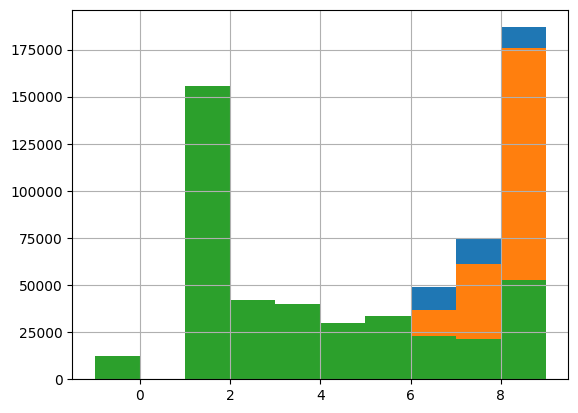

In [94]:
def add_index_range_series(series):
    # get in the format of 0-100, 100-200, etc.
    return series.min().astype(int).astype(str) + '-' + series.max().astype(int).astype(str)
# all_ratings_llm = all_ratings_llm.drop(columns=['_id', 'prefix_index', 'prompt_index'])
for llm_name in llm_to_index:
    all_ratings_llm_formatted = pd.read_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}.csv')
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['num_tries', 'latency'])
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['_id', 'prefix_index', 'prompt_index'])
    all_ratings_llm_formatted['item_index'] +=1
    all_ratings_llm_formatted['llm_index'] +=1
    all_ratings_llm_formatted['sample_index'] +=1
    all_ratings_llm_formatted['rating'] = all_ratings_llm_formatted['rating'].astype(int).astype(str).replace('-1', '.')
    all_ratings_llm_formatted['rating'].replace('.', '-1').astype(int).hist(bins=10)
    all_ratings_llm_formatted = all_ratings_llm_formatted.sort_values('item_index')\
        .groupby(['sample_index', 'llm_index'])\
        .agg({'item_index': add_index_range_series, 'rating': list})\
        .reset_index()
    s = all_ratings_llm_formatted['rating']
    ratings_df = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
    all_ratings_llm_formatted = all_ratings_llm_formatted.drop(columns=['rating'])
    all_ratings_llm_formatted = pd.concat([all_ratings_llm_formatted, ratings_df], axis=1)
    all_ratings_llm_formatted.to_csv(f'temp/contrast/{dim}_ratings_llm_{llm_to_index[llm_name]}_formatted.csv', index=False, header=False)
